In [1]:
import numpy as np
import skimage.io
import skimage.filters
import skimage.morphology
import pandas as pd
import sys

##add the path containing Jwags video analysis files
sys.path.append("behavioral_analysis/")

import segmentation as jwseg 

import motmot.FlyMovieFormat.FlyMovieFormat as FMF

# Opening the flymovie file and creating a background image

In [3]:
#File path the the video file
fname = '/data/2019_03_15_Liometopum_solo\
_test_cam_0_date_2019_03_15_time_\
14_39_32_v001.fmf.3F4BFEBC'

In [6]:
#create FMF object of the movie and get image dimensions
fmf = FMF.FlyMovie(fname)
frame_width = fmf.get_width()
frame_height = fmf.get_height()

In [7]:
#get the number of frames 
frame_num = fmf.get_n_frames()

In [8]:
bg_img_set = []
for frame_number in range(100):
    frame,timestamp = fmf.get_frame(frame_number)
    bg_img_set.append(frame)

In [9]:
bg_img = jwseg.construct_bg_img(bg_img_set)

/home/ubuntu/miniconda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


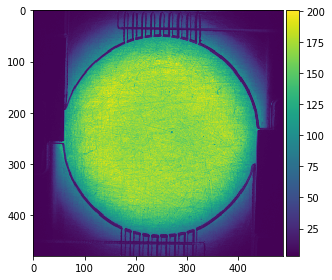

In [10]:
skimage.io.imshow(bg_img)

# Slightly modified functons written by Julian Wagner
Used to perform bg subtraction and meausure the region props of images

In [11]:
def bg_subtract(im1, im2):
    """Function to perform background subtraction on an image
    using a blank image of the arena of interest.
    
    Parameters
    ----------
    im1 : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to subtract the
        background from.
    im2 : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The background image (with only one color chanel) to subtract the
        from im1.
    Returns
    -------
    output : 2d numpy.ndarray with shape (n, m)
        image with background subtracted, i.e. im1-im2.
    """
    im1 = normalize_convert_im(im1)
    im2 = normalize_convert_im(im2)
    
    im_no_bg = im1-im2
    im_no_bg = normalize_convert_im(im_no_bg)
    return (im_no_bg)

In [12]:
def normalize_convert_im(im):
    """Function to normalize an image and convert it to float type.
    Normalized image is between 0. and 1.0.
    
    Parameters
    ----------
    im : numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to get ROI from.
    
    Returns
    -------
    output : 2d numpy.ndarray with shape (n, m) of type float 
    and in range of 0. to 1.0.
    """
    
    im = skimage.img_as_float(im)
    im_norm = im - im.min()
    im_norm = im_norm / im_norm.max()
    return im_norm

In [13]:
def segment(im, thresh_func=skimage.filters.threshold_otsu, args=()):
    """Function to threshold an image using skimage functions. 
    The user pases the desired function to determine the threshold
    for the data (or a value to use as the threshold). This value
    for the threshold level can be a float/int or an array of same shape
    as the input image.
    
    Parameters
    ----------
    x : im, numpy.ndarray with shape (n, m) (with 0 < m, n)
        The image (with only one color chanel) to threshold.
    thresh_func : function
        The function to use to calculate the thresholding. Should
        return a single scalar value or a numpy array.
    Returns
    -------
    im_bw : 2d numpy.ndarray with shape (n, m)
        Boolean array with location of thresholded objects.
    im_labeled : a labelfield of image
    n_labels : number of identified objects in the labelfield
    """
    thresh = thresh_func(im, *args)
    im_bw = im < thresh
    
    #Remove small objects, i.e. insect legs that are recognized as separate objects
    #from the insect body
    im_bw_big_objs = skimage.morphology.remove_small_objects(im_bw)
    
    # Label binary image; background kwarg says value in im_bw to be background
    im_labeled, n_labels = skimage.measure.label(im_bw_big_objs, background=0, return_num=True)
    
    return im_bw, im_labeled, n_labels

In [14]:
def region_props_to_tuple(rp):
    """Function to extract the region properties from a regionprops
    object.
    
    Parameters
    ----------
    rp : skimage.measure._regionprops._RegionProperties, a region properties
        object from which to extract attributes
    Returns
    -------
    attributes : tuple. The regionproperty fields for many properites of a blob
    labels : tuple. The corresponding label for teh values in attributes
    """     
    labels = ('area', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row', 'bbox_max_col', 'bbox_area',
              'centroid_row', 'centroid_col', 'convex_area', 'eccentricity', 'equivalent_diameter',
              'euler_number', 'extent', 'filled_area', 'label', 'local_centroid_row', 'local_centoid_col',
              'major_axis_length', 'max_intensity', 'mean_intensity', 'min_intensity', 'minor_axis_length',
              'orientation', 'perimeter', 'solidity', 'weighted_centroid_row', 'weighted_centroid_col',
              'weighted_local_centoid_row', 'weighted_local_centroid_col')
    
    bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col = rp.bbox
    centroid_row, centroid_col = rp.centroid
    local_centroid_row, local_centoid_col = rp.local_centroid
    weighted_centroid_row, weighted_centroid_col = rp.weighted_centroid
    weighted_local_centoid_row, weighted_local_centroid_col = rp.weighted_local_centroid

    attributes = (rp.area, bbox_min_row, bbox_min_col, bbox_max_row, bbox_max_col,
                  rp.bbox_area, centroid_row, centroid_col, rp.convex_area, 
                  rp.eccentricity, rp.equivalent_diameter, rp.euler_number,
                  rp.extent, rp.filled_area, rp.label, local_centroid_row,
                  local_centoid_col, rp.major_axis_length, rp.max_intensity,
                  rp.mean_intensity, rp.min_intensity, rp.minor_axis_length,
                  rp.orientation, rp.perimeter, rp.solidity,
                  weighted_centroid_row, weighted_centroid_col,
                  weighted_local_centoid_row, weighted_local_centroid_col)
    
    return attributes, labels

## Creating a function that combines the above functions into something that can be multithreaded

In [1]:
def image_analysis(curr_im, bg_im):
    """Combines functions to perform background subtraction of an image
    threshold the image, identify objects in the thresholded image,
    and generate region props for the image
    
    Parameters
    ----------
    curr_im : current image being analyzed
    bg_im : background image generated from dataset
    
    Returns
    -------
    attributes : tuple. The regionproperty fields for many properites of a blob
    labels : tuple. The corresponding label for teh values in attributes
    """     

    frame_nobg = bg_subtract(curr_im, bg_im)
    
    frame_thresh,frame_label,label_nums = segment(frame_nobg)
    
    frame_rp = skimage.measure.regionprops(frame_label,frame_nobg)
    
    frame_attributes,_ = region_props_to_tuple(frame_rp[0])